<a href="https://colab.research.google.com/github/rickyhndrwn/TubesPM-18_247-18_249/blob/main/tugas_besar_pm_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Tugas Besar Pembelajaran Mesin 7D 2021**
---
- 201810370311247 - Ricky Hendrwan (Ketua)
- 201810370311249 - Shofiyah (Anggota)

### Import library

In [1]:
import os
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten, Input

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint

import json

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import numpy as np

from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras.models import load_model

### Downsampling

In [2]:
base_dir = '/content/drive/MyDrive/Dataset/chest_xray'

norm_dir = os.path.join(base_dir, 'normal')
pneu_dir = os.path.join(base_dir, 'pneumonia')

In [3]:
norm_data_count = len(os.listdir(norm_dir))
pneu_data_count = len(os.listdir(pneu_dir))

print(f"Jumlah Normal: {norm_data_count}\nJumlah Pneoumonia: {pneu_data_count}")

Jumlah Normal: 1583
Jumlah Pneoumonia: 4273


In [4]:
pneu_img_dest = os.path.join(base_dir, 'pneumonia_reduced_data_count/')
pneu_img_names = os.listdir(pneu_dir)
pneu_img_names = random.sample(pneu_img_names, norm_data_count)

for pneu_img in pneu_img_names:
    pneu_img_dir = os.path.join(pneu_dir, pneu_img)
    os.makedirs(os.path.dirname(pneu_img_dest), exist_ok=True)
    shutil.copy(pneu_img_dir, pneu_img_dest)

In [5]:
rsmpled_pneu_dir = os.path.join(base_dir, 'pneumonia_reduced_data_count')
rsmpled_pneu_data_count = len(os.listdir(rsmpled_pneu_dir))
print(f"Jumlah Normal: {norm_data_count}\nJumlah Undersampled Pneoumonia: {rsmpled_pneu_data_count}")

Jumlah Normal: 1583
Jumlah Undersampled Pneoumonia: 1583


### Define path

In [ ]:
base_dir = '/content/drive/MyDrive/Dataset/chest_xray'

splitted_dir = os.path.join(base_dir, 'splitted_resampled_data')

train_dir = os.path.join(splitted_dir, 'train')
norm_train_dir = os.path.join(train_dir, 'normal')
pneu_train_dir = os.path.join(train_dir, 'pneumonia_reduced_data_count')

val_dir = os.path.join(splitted_dir, 'val')
norm_val_dir = os.path.join(val_dir, 'normal')
pneu_val_dir = os.path.join(val_dir, 'pneumonia_reduced_data_count')

test_dir = os.path.join(splitted_dir, 'test')
norm_test_dir = os.path.join(test_dir, 'normal')
pneu_test_dir = os.path.join(test_dir, 'pneumonia_reduced_data_count')

In [ ]:
print("Total Training NORMAL:", len(os.listdir(norm_train_dir)))
print("Total Training PNEUMONIA:", len(os.listdir(pneu_train_dir)))
print('-'*30)
print("Total validation NORMAL:", len(os.listdir(norm_val_dir)))
print("Total validation PNEUMONIA:", len(os.listdir(pneu_val_dir)))
print('-'*30)
print("Total Testing NORMAL:", len(os.listdir(norm_test_dir)))
print("Total Testing PNEUMONIA:", len(os.listdir(pneu_test_dir)))

Total Training NORMAL: 1266
Total Training PNEUMONIA: 1266
------------------------------
Total validation NORMAL: 300
Total validation PNEUMONIA: 300
------------------------------
Total Testing NORMAL: 17
Total Testing PNEUMONIA: 17


In [ ]:
train_data_count = len(os.listdir(norm_train_dir)) + len(os.listdir(pneu_train_dir))
val_data_count = len(os.listdir(norm_val_dir)) + len(os.listdir(pneu_val_dir))
test_data_count = len(os.listdir(norm_test_dir)) + len(os.listdir(pneu_test_dir))
total_data_count = train_data_count + val_data_count + test_data_count

print("Persentase Pembagian Data:")
print(f"\ttrain = {train_data_count / total_data_count * 100:.0f} %")
print(f"\tval = {val_data_count / total_data_count * 100:.0f} %")
print(f"\ttest = {test_data_count / total_data_count * 100:.0f} %")

Persentase Pembagian Data:
	train = 80 %
	val = 19 %
	test = 1 %


### Augmentation

In [ ]:
img_target_size = (180, 180)

train_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.4,
    horizontal_flip=True
    )

train_gen = train_aug.flow_from_directory(
    train_dir,
    class_mode='categorical',
    target_size=img_target_size
    )

val_test_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

val_gen = val_test_aug.flow_from_directory(
    val_dir,
    class_mode='categorical',
    target_size=img_target_size
    )

test_gen = val_test_aug.flow_from_directory(
    test_dir,
    class_mode=None,
    shuffle=False,
    target_size=img_target_size
    )

Found 2532 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 34 images belonging to 2 classes.


### Modelling

#### DenseNet-201

In [ ]:
densenet201_base = DenseNet201(
    include_top=False,
    input_shape=(180, 180, 3)
    )

for layer in densenet201_base.layers:
    layer.trainable = False

74850304/74836368 [==============================] - 1s 0us/step


##### FC layer

In [ ]:
model = Sequential()

model.add(densenet201_base)

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(2, activation='softmax'))

# print(model.summary())

#### Model viz

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model,
           to_file='cxr_dn201.png',
           show_shapes=True,
        #    show_layer_names=False
           )

### Compile

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Callback

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

target_dir = '/content/drive/MyDrive/Colab Notebooks/Tugas Kelompok Praktikum PM 2021'
directory_to_save_best_model_file = target_dir + '/cxr_dn201_skim_4_bst_chkpnt_downsampled_v5.h5'
best_model = ModelCheckpoint(directory_to_save_best_model_file,
                             monitor='val_accuracy',
                             save_best_only = True
                             )

### Fitting

In [ ]:
H = model.fit(train_gen,
              validation_data=val_gen,
              epochs=30,
              verbose=1,
              callbacks=best_model)

Epoch 1/30
80/80 [==============================] - 1132s 14s/step - loss: 0.4208 - accuracy: 0.8357 - val_loss: 0.9237 - val_accuracy: 0.7717
Epoch 2/30
80/80 [==============================] - 465s 6s/step - loss: 0.2830 - accuracy: 0.8961 - val_loss: 0.4507 - val_accuracy: 0.8517
Epoch 3/30
80/80 [==============================] - 470s 6s/step - loss: 0.2459 - accuracy: 0.9068 - val_loss: 0.3088 - val_accuracy: 0.8817
Epoch 4/30
80/80 [==============================] - 471s 6s/step - loss: 0.2385 - accuracy: 0.9080 - val_loss: 0.1634 - val_accuracy: 0.9300
Epoch 5/30
80/80 [==============================] - 464s 6s/step - loss: 0.2117 - accuracy: 0.9119 - val_loss: 0.2227 - val_accuracy: 0.9150
Epoch 6/30
80/80 [==============================] - 464s 6s/step - loss: 0.2124 - accuracy: 0.9167 - val_loss: 0.1597 - val_accuracy: 0.9350
Epoch 7/30
80/80 [==============================] - 462s 6s/step - loss: 0.1993 - accuracy: 0.9238 - val_loss: 0.2598 - val_accuracy: 0.9100
Epoch 8/30


### Save model and history

In [ ]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/Tugas Kelompok Praktikum PM 2021/'

json.dump(H.history, open(save_dir + '/cxr_dn201_skim_4_25E_downsampled_v5.json', 'w'))
model.save(save_dir + '/cxr_dn201_skim_4_25E_downsampled_v5.h5')

### Load model and history

In [ ]:
from keras.models import load_model
import json

target_dir = '/content/drive/MyDrive/Colab Notebooks/Tugas Kelompok Praktikum PM 2021'
directory_to_save_best_model_file = target_dir + '/cxr_dn201_skim_4_25E_downsampled_v5.h5'
model = load_model(directory_to_save_best_model_file)

save_dir = '/content/drive/MyDrive/Colab Notebooks/Tugas Kelompok Praktikum PM 2021/'
history = json.load(open(save_dir + '/cxr_dn201_skim_4_25E_downsampled_v5.json', 'r'))

### Plot loss acc

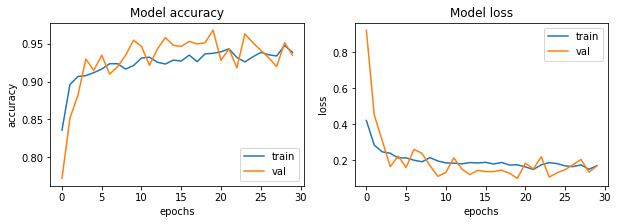

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(H.history[met])
    ax[i].plot(H.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Classification report

In [ ]:
y_true = test_gen.classes

pred_result = model.predict(test_gen)
y_pred = np.argmax(pred_result, axis=-1)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.94      0.94      0.94        17

    accuracy                           0.94        34
   macro avg       0.94      0.94      0.94        34
weighted avg       0.94      0.94      0.94        34



In [ ]:
acc = accuracy_score(y_true, y_pred)
prec, recll, fcsore, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')

print(f"Accuracy\t: {round(acc * 100, 2)}%")
print(f"Precision\t: {round(prec * 100, 2)}%")
print(f"Recall\t\t: {round(recll * 100, 2)}%")
print(f"F1-Score\t: {round(fcsore * 100, 2)}%")

Accuracy	: 94.12%
Precision	: 94.12%
Recall		: 94.12%
F1-Score	: 94.12%


### Confusion matrix

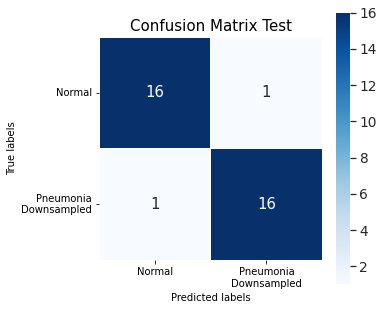

In [ ]:
# labels = test_gen.class_indices
# labels = [label.replace("_", "\n").title() for label in labels]
labels = ['Normal', 'Pneumonia\nDownsampled']

cmatrix_result = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
ax = plt.subplot()

data = np.asarray(cmatrix_result).reshape(2,2)

sns.set(font_scale=1.25)
sns.heatmap(data,
            annot=True,
            ax=ax,
            cmap="Blues",
            square=True,
            linewidths=.3,
            xticklabels=labels,
            yticklabels=labels
            )

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

plt.yticks(rotation=0)
plt.title('Confusion Matrix Test')
plt.show()

### Predict image

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import cv2
import time
import numpy as np

def pred_with_h5(img_to_pred):
    start_pred_time = time.time()
    pred_result = model.predict(img_to_pred)
    end_pred_time = time.time()

    confidence_percent = round(np.max(pred_result) * 100, 2)

    pred_value = np.argmax(pred_result)
    pred_label = 'normal' if pred_value == 0 else 'pneumonia'

    pred_time = round(end_pred_time - start_pred_time, 4)

    return pred_label, confidence_percent, pred_time

def pred_img(img_path):
    img = load_img(img_path, target_size=img_target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = np.vstack([img])

    pred_result = pred_with_h5(img)

    return pred_result

In [ ]:
from random import shuffle

norm_files = os.listdir(norm_test_dir)
pneu_files = os.listdir(pneu_test_dir)

norm_name_dir = [os.path.join(norm_test_dir, fname) for fname in norm_files]
pneu_name_dir = [os.path.join(pneu_test_dir, fname) for fname in pneu_files[:34]]

norm_pneu_dir = norm_name_dir + pneu_name_dir

In [ ]:
shuffle(norm_pneu_dir)

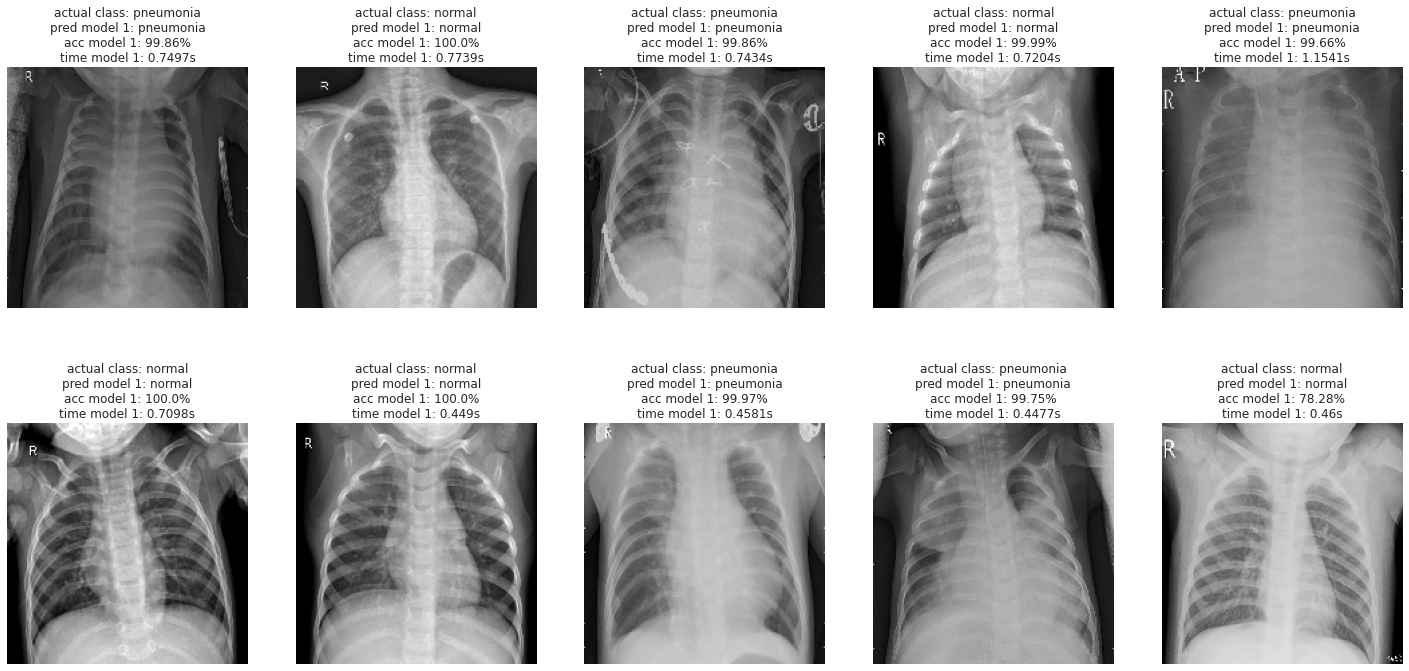

In [ ]:
img_target_size = (180, 180)

nrows = 2
ncols = 5

fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 6)

for i, img_path in enumerate(norm_pneu_dir[:10]):
    plt.subplot(nrows, ncols, i + 1)
    # plt.subplots_adjust(hspace=0.5, wspace=0.5)

    img = cv2.imread(img_path)
    img = cv2.resize(img, img_target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # nama_citra = os.path.basename(img_path)
    true_label = img_path.split(os.path.sep)[-2]

    pred_result = pred_img(img_path)
    pred_label = pred_result[0]
    confidence_percent = pred_result[1]
    pred_time = pred_result[2]
    
    title_string = f"actual class: {true_label}"
    title_string = title_string + f"\npred model 1: {pred_label}"
    title_string = title_string + f"\nacc model 1: {confidence_percent}%"
    title_string = title_string + f"\ntime model 1: {pred_time}s"

    title_string = title_string if true_label == pred_label else 'MISS\n' + title_string

    plt.grid(False)
    plt.axis(False)
    plt.title(title_string, fontdict={'fontsize': 12})
    plt.imshow(img)

plt.show()